In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor
import pymannkendall as mk
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
# read processed data from pkl file
pkl_file = open('NH_winter_temp_anom.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)

# recover the original values by adding the climatology
with xr.open_dataset(path_ + pre_ + '1980.nc') as ds:
    climatology = ds.climatology.values[:,-90:,:]

doy_l = [0, 31, 59, 304, 334]
doy_r = [31, 59, 90, 334, 365]
ll = [0, 31, 59, 90, 120, 151]
for yy in range(40):
    for mm in range(5):
        il, ir = 151*yy + ll[mm], 151*yy + ll[mm+1]
        temp[il:ir,:,:] += climatology[doy_l[mm]:doy_r[mm],:,:]

temp = temp[90:-61,:,:]

In [3]:
temp_climatology = np.mean(temp, axis=0)
temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp, axis=0))
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [14]:
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

comp_gridded = []
comp_insitu = []
climatology_v = []
climatology_v2 = []

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue
        # if swe_gridded[i,j] > 4:
        #     continue
    
        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        mk_res1 = mk.original_test(temp_mean[:,i,j])
        
        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        mk_res2 = mk.original_test(temp_median[:,i,j])

        climatology_v.append(temp_climatology[i,j])


        comp_gridded.append((lm1.coef_[0]*10, lm2.coef_[0]*10, swe_gridded[i,j]))
        if swe_insitu[i,j] != 0:
            comp_insitu.append((lm1.coef_[0]*10, lm2.coef_[0]*10, swe_insitu[i,j]))
            climatology_v2.append(temp_climatology[i,j])
        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)
climatology_v = np.array(climatology_v)
climatology_v2 = np.array(climatology_v2)

# comp_gridded[:,0] is the slope of the mean temperature (daily winter temperature)
# comp_gridded[:,1] is the slope of the median temperature (daily winter temperature)
# comp_gridded[:,2] is the Mar SWE trend
        

Processing  1000  grids. Time taken so far:  21.804510593414307
Processing  2000  grids. Time taken so far:  45.13388419151306
Processing  3000  grids. Time taken so far:  68.22615671157837
Processing  4000  grids. Time taken so far:  91.69011783599854
Processing  5000  grids. Time taken so far:  116.40174388885498
Processing  6000  grids. Time taken so far:  141.43146061897278
Processing  7000  grids. Time taken so far:  167.15275645256042


In [6]:
_, rho_mean_gridded, rho_median_gridded, rho_diff_gridded = np.corrcoef([comp_gridded[:,2], comp_gridded[:,0], comp_gridded[:,1], comp_gridded[:,1] - comp_gridded[:,0] ])[0,:]
_, rho_mean_insitu, rho_median_insitu, rho_diff_insitu = np.corrcoef([comp_insitu[:,2], comp_insitu[:,0], comp_insitu[:,1], comp_insitu[:,1] - comp_insitu[:,0] ])[0,:]

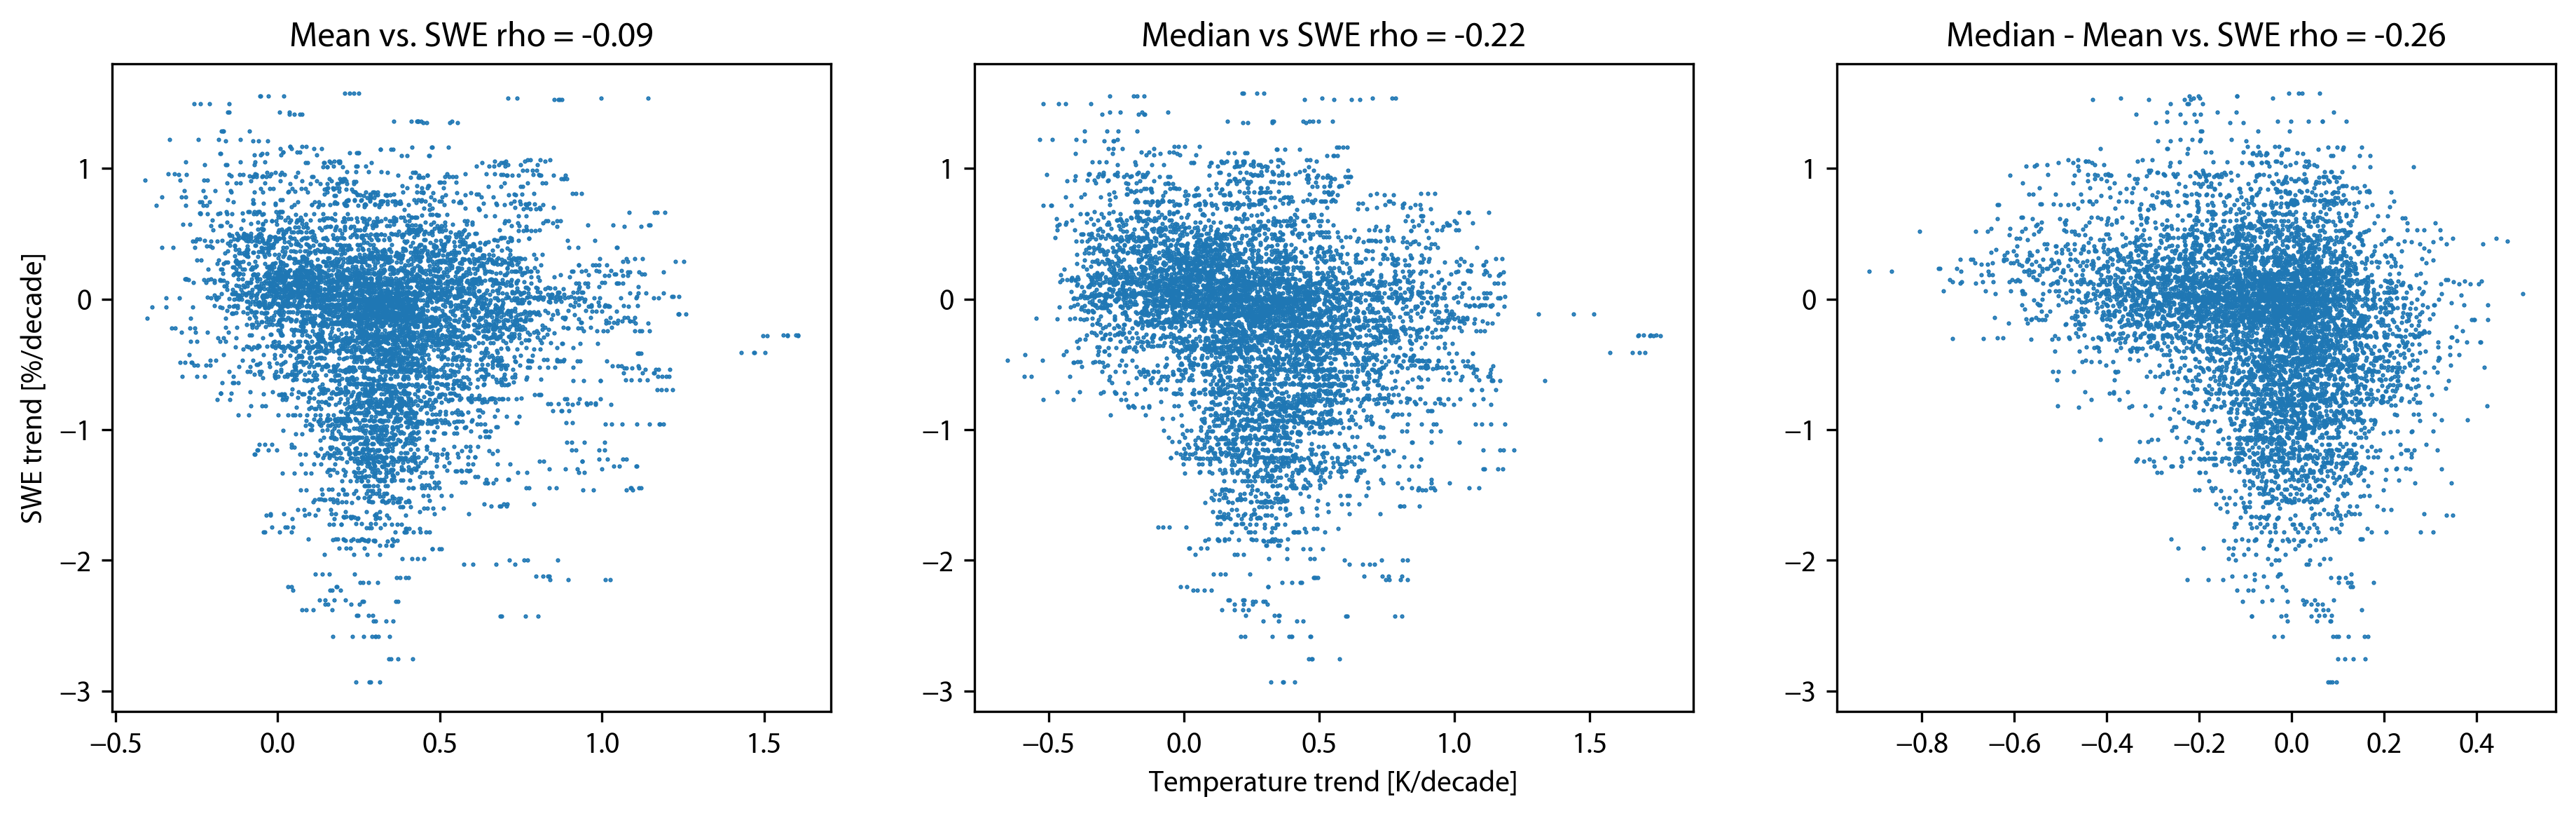

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(comp_gridded[:,0], comp_gridded[:,2], s=1, marker='.')
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_gridded))
ax[0].set_ylabel('SWE trend [%/decade]')
ax[1].scatter(comp_gridded[:,1], comp_gridded[:,2], s=1, marker='.')
ax[1].set_title('Median vs SWE rho = {:.2f}'.format(rho_median_gridded))
ax[1].set_xlabel('Temperature trend [K/decade]')
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_gridded))
ax[2].scatter(comp_gridded[:,1] - comp_gridded[:,0], comp_gridded[:,2], s=1, marker='.')


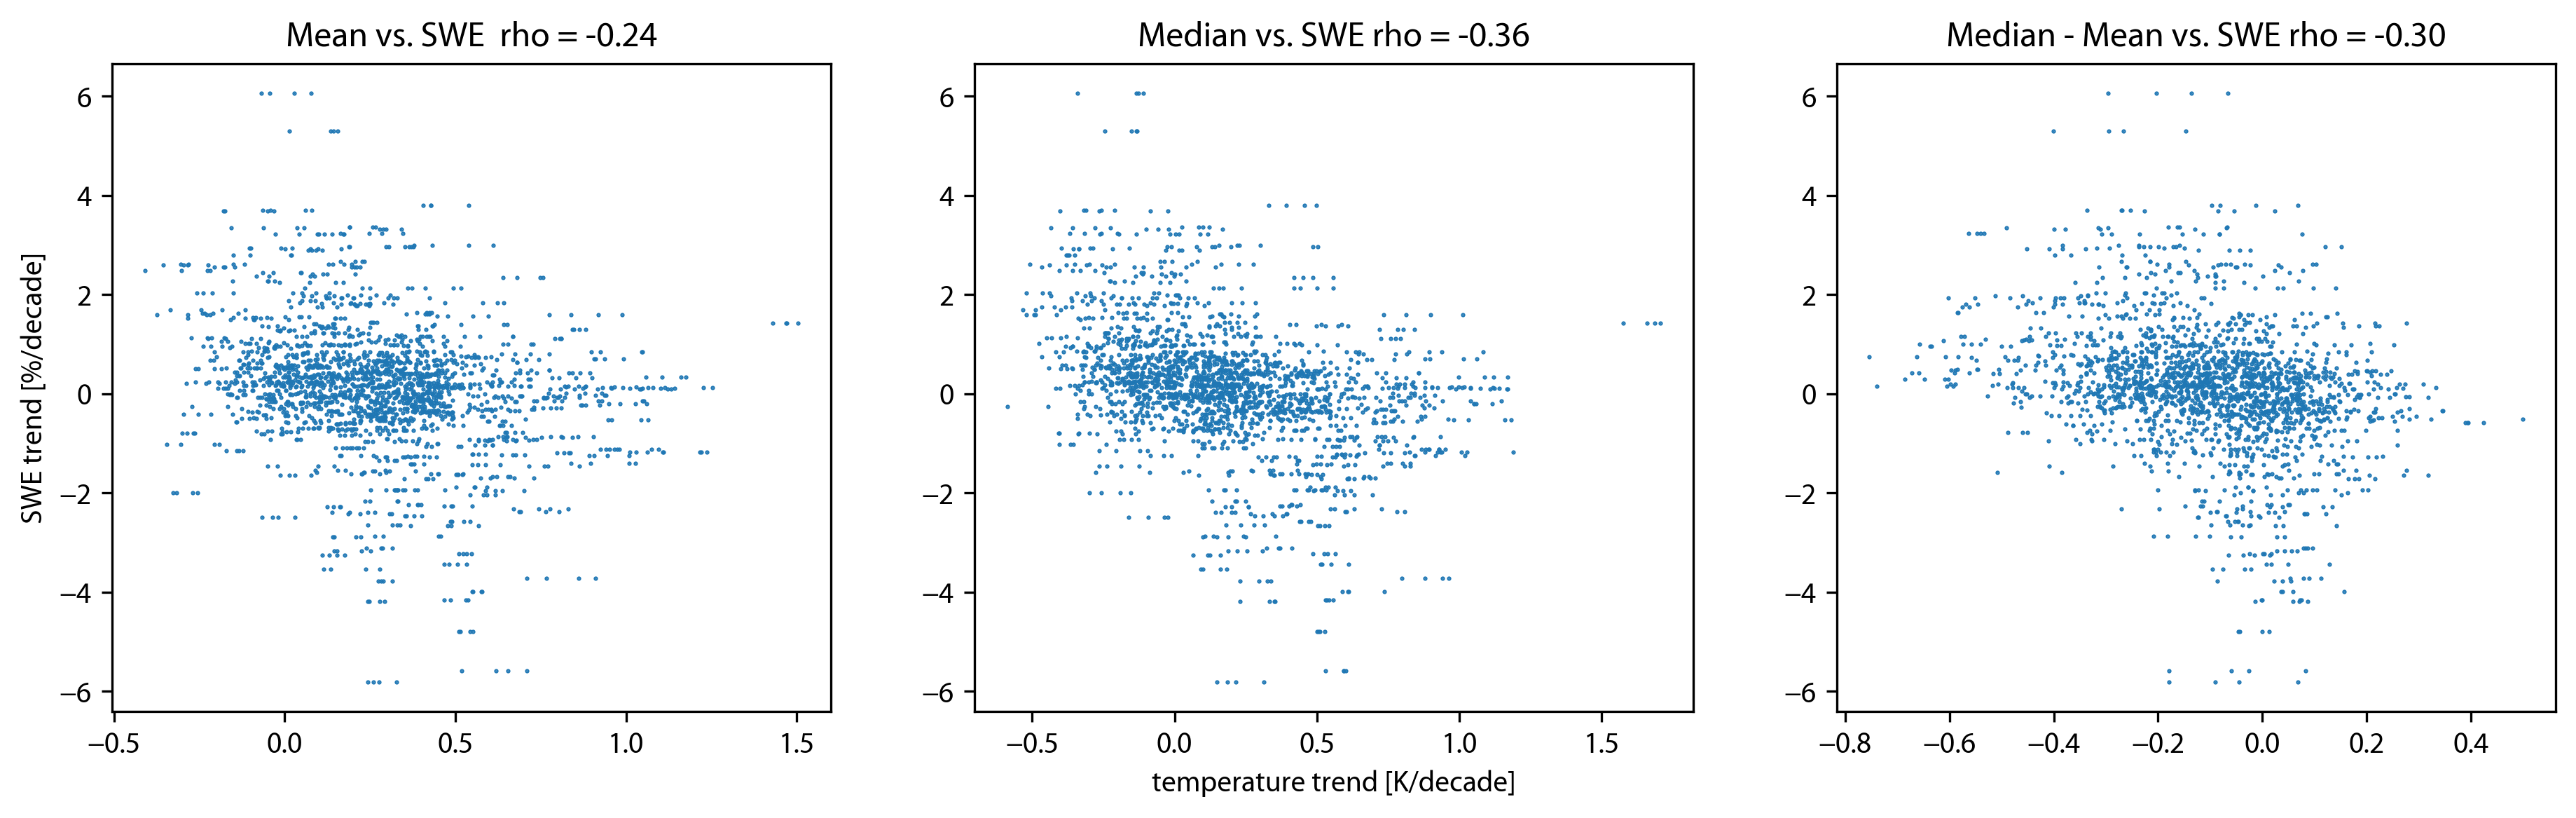

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(comp_insitu[:,0], comp_insitu[:,2], s=1, marker='.')
ax[0].set_title('Mean vs. SWE  rho = {:.2f}'.format(rho_mean_insitu))
ax[0].set_ylabel('SWE trend [%/decade]')
ax[1].scatter(comp_insitu[:,1], comp_insitu[:,2], s=1, marker='.')
ax[1].set_title('Median vs. SWE rho = {:.2f}'.format(rho_median_insitu))
ax[1].set_xlabel('temperature trend [K/decade]')
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_insitu))
ax[2].scatter(comp_insitu[:,1] - comp_insitu[:,0], comp_insitu[:,2], s=1, marker='.')

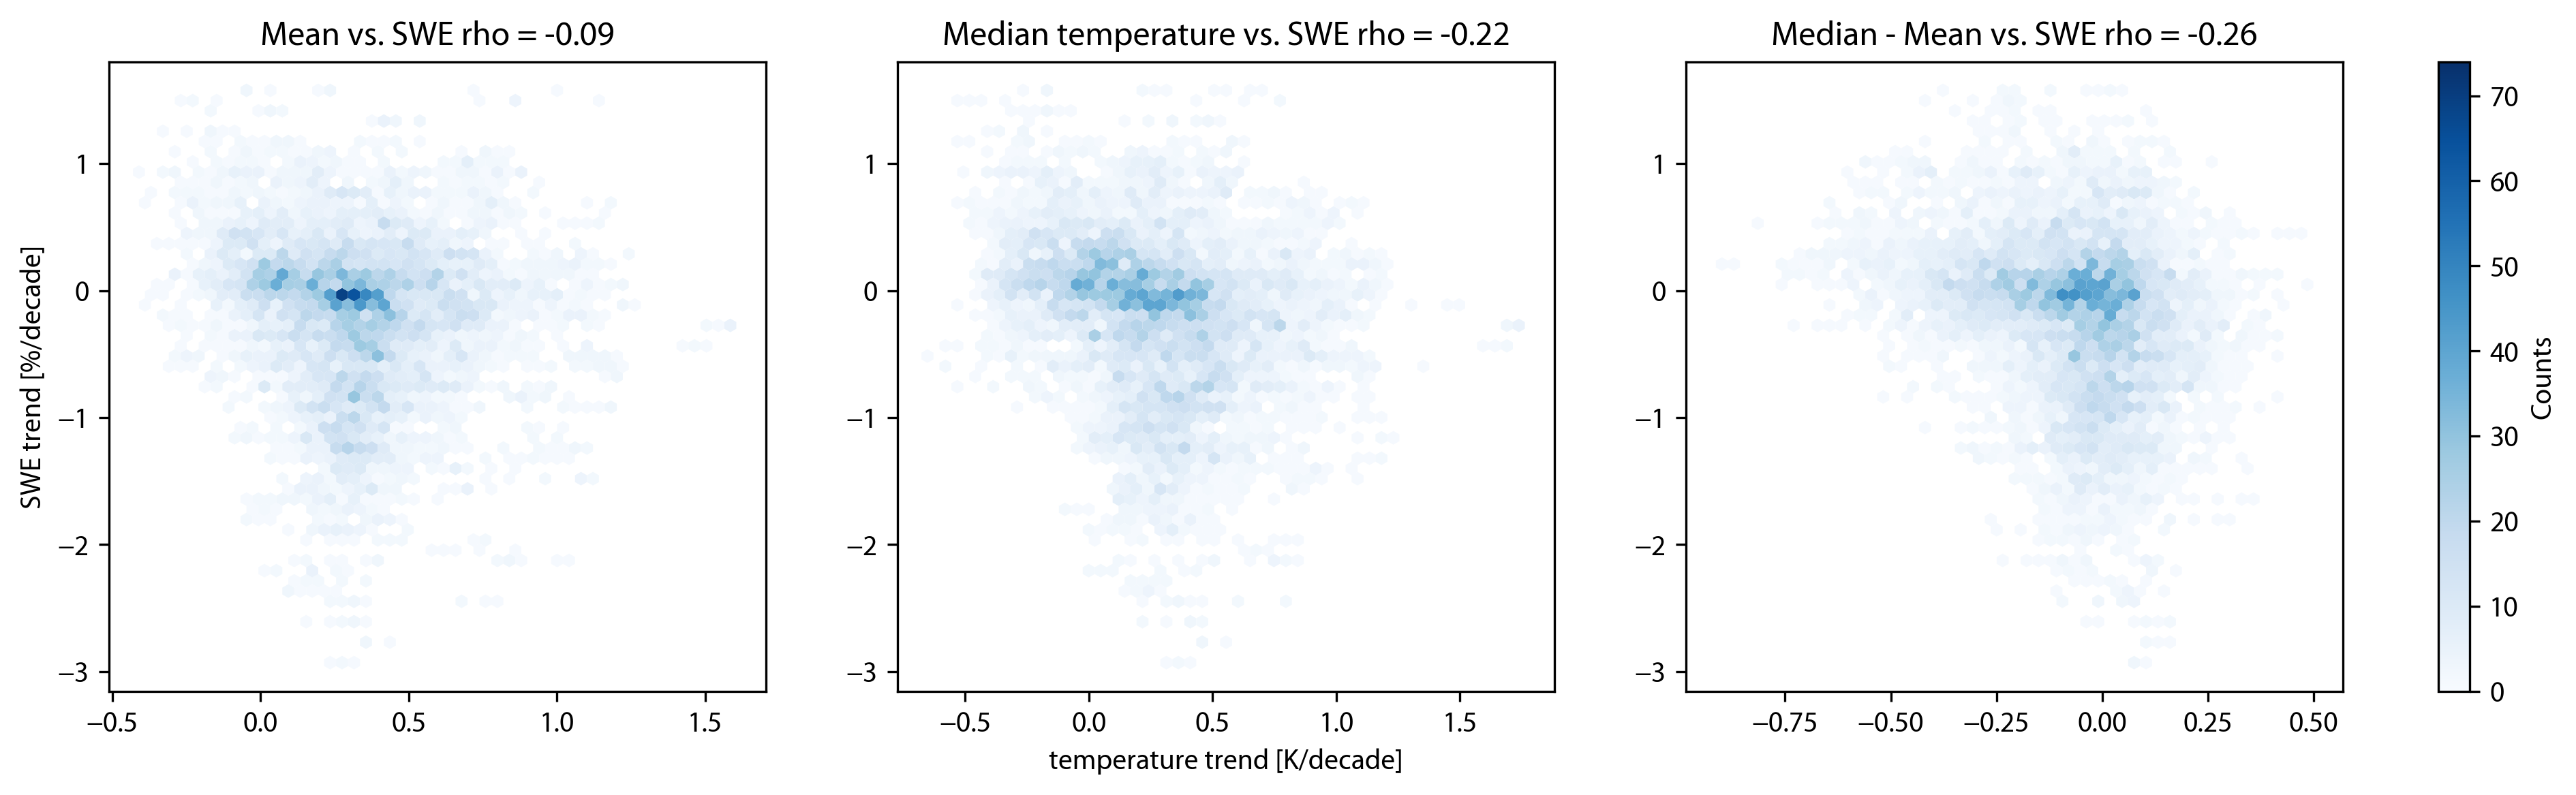

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

combined_density = np.concatenate([
    np.histogram2d(comp_gridded[:, 0], comp_gridded[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_gridded[:, 1], comp_gridded[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_gridded[:, 1] - comp_gridded[:, 0], comp_gridded[:, 2], bins=50)[0].flatten()
])

max_density = combined_density.max()

hb = ax[0].hexbin(comp_gridded[:,0], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_gridded))
ax[0].set_ylabel('SWE trend [%/decade]')

hb = ax[1].hexbin(comp_gridded[:,1], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[1].set_title('Median temperature vs. SWE rho = {:.2f}'.format(rho_median_gridded))
ax[1].set_xlabel('temperature trend [K/decade]')

hb = ax[2].hexbin(comp_gridded[:,1] - comp_gridded[:,0], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_gridded))

# Add a single colorbar for all plots
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# plt.tight_layout()
plt.show()

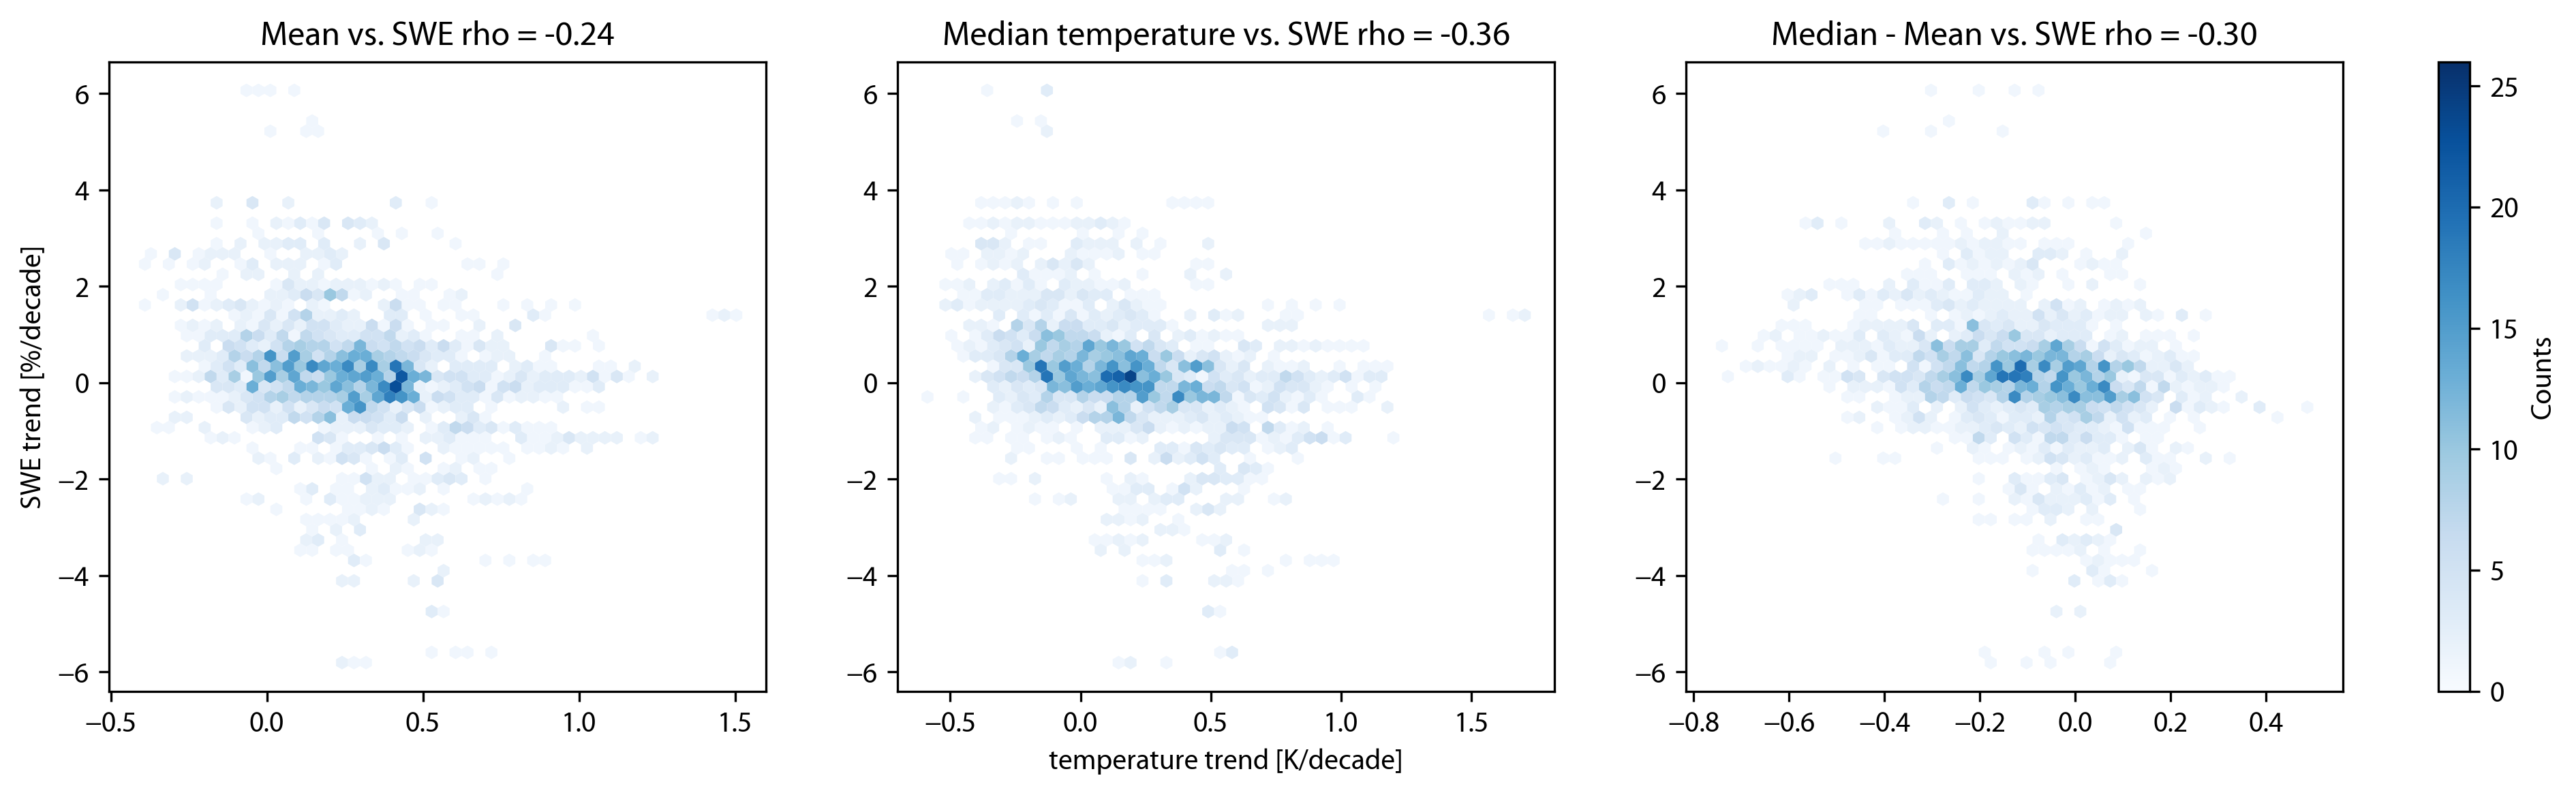

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

combined_density = np.concatenate([
    np.histogram2d(comp_insitu[:, 0], comp_insitu[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_insitu[:, 1], comp_insitu[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_insitu[:, 1] - comp_insitu[:, 0], comp_insitu[:, 2], bins=50)[0].flatten()
])

max_density = combined_density.max()

hb = ax[0].hexbin(comp_insitu[:,0], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_insitu))
ax[0].set_ylabel('SWE trend [%/decade]')

hb = ax[1].hexbin(comp_insitu[:,1], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[1].set_title('Median temperature vs. SWE rho = {:.2f}'.format(rho_median_insitu))
ax[1].set_xlabel('temperature trend [K/decade]')

hb = ax[2].hexbin(comp_insitu[:,1] - comp_insitu[:,0], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_insitu))

# Add a single colorbar for all plots
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# plt.tight_layout()
plt.show()

(array([  4.,   4.,   8.,  16.,  16.,  24.,  16.,  36.,  52.,  80.,  96.,
        152., 204., 208., 272., 324., 360., 428., 556., 724., 976., 852.,
        576., 368., 300., 164., 144., 116.,  68.,  12.,  20.,  20.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.]),
 array([-2.92873408, -2.7874127 , -2.64609132, -2.50476994, -2.36344856,
        -2.22212717, -2.08080579, -1.93948441, -1.79816303, -1.65684165,
        -1.51552027, -1.37419889, -1.23287751, -1.09155613, -0.95023475,
        -0.80891336, -0.66759198, -0.5262706 , -0.38494922, -0.24362784,
        -0.10230646,  0.03901492,  0.1803363 ,  0.32165768,  0.46297906,
         0.60430044,  0.74562183,  0.88694321,  1.02826459,  1.16958597,
         1.31090735,  1.45222873,  1.59355011,  1.73487149,  1.87619287,
         2.01751426,  2.15883564,  2.30015702,  2.4414784 ,  2.58279978,
         2.72412116,  2.86544254,  3.00676392,  3.1480853 ,  3.28940668,
 

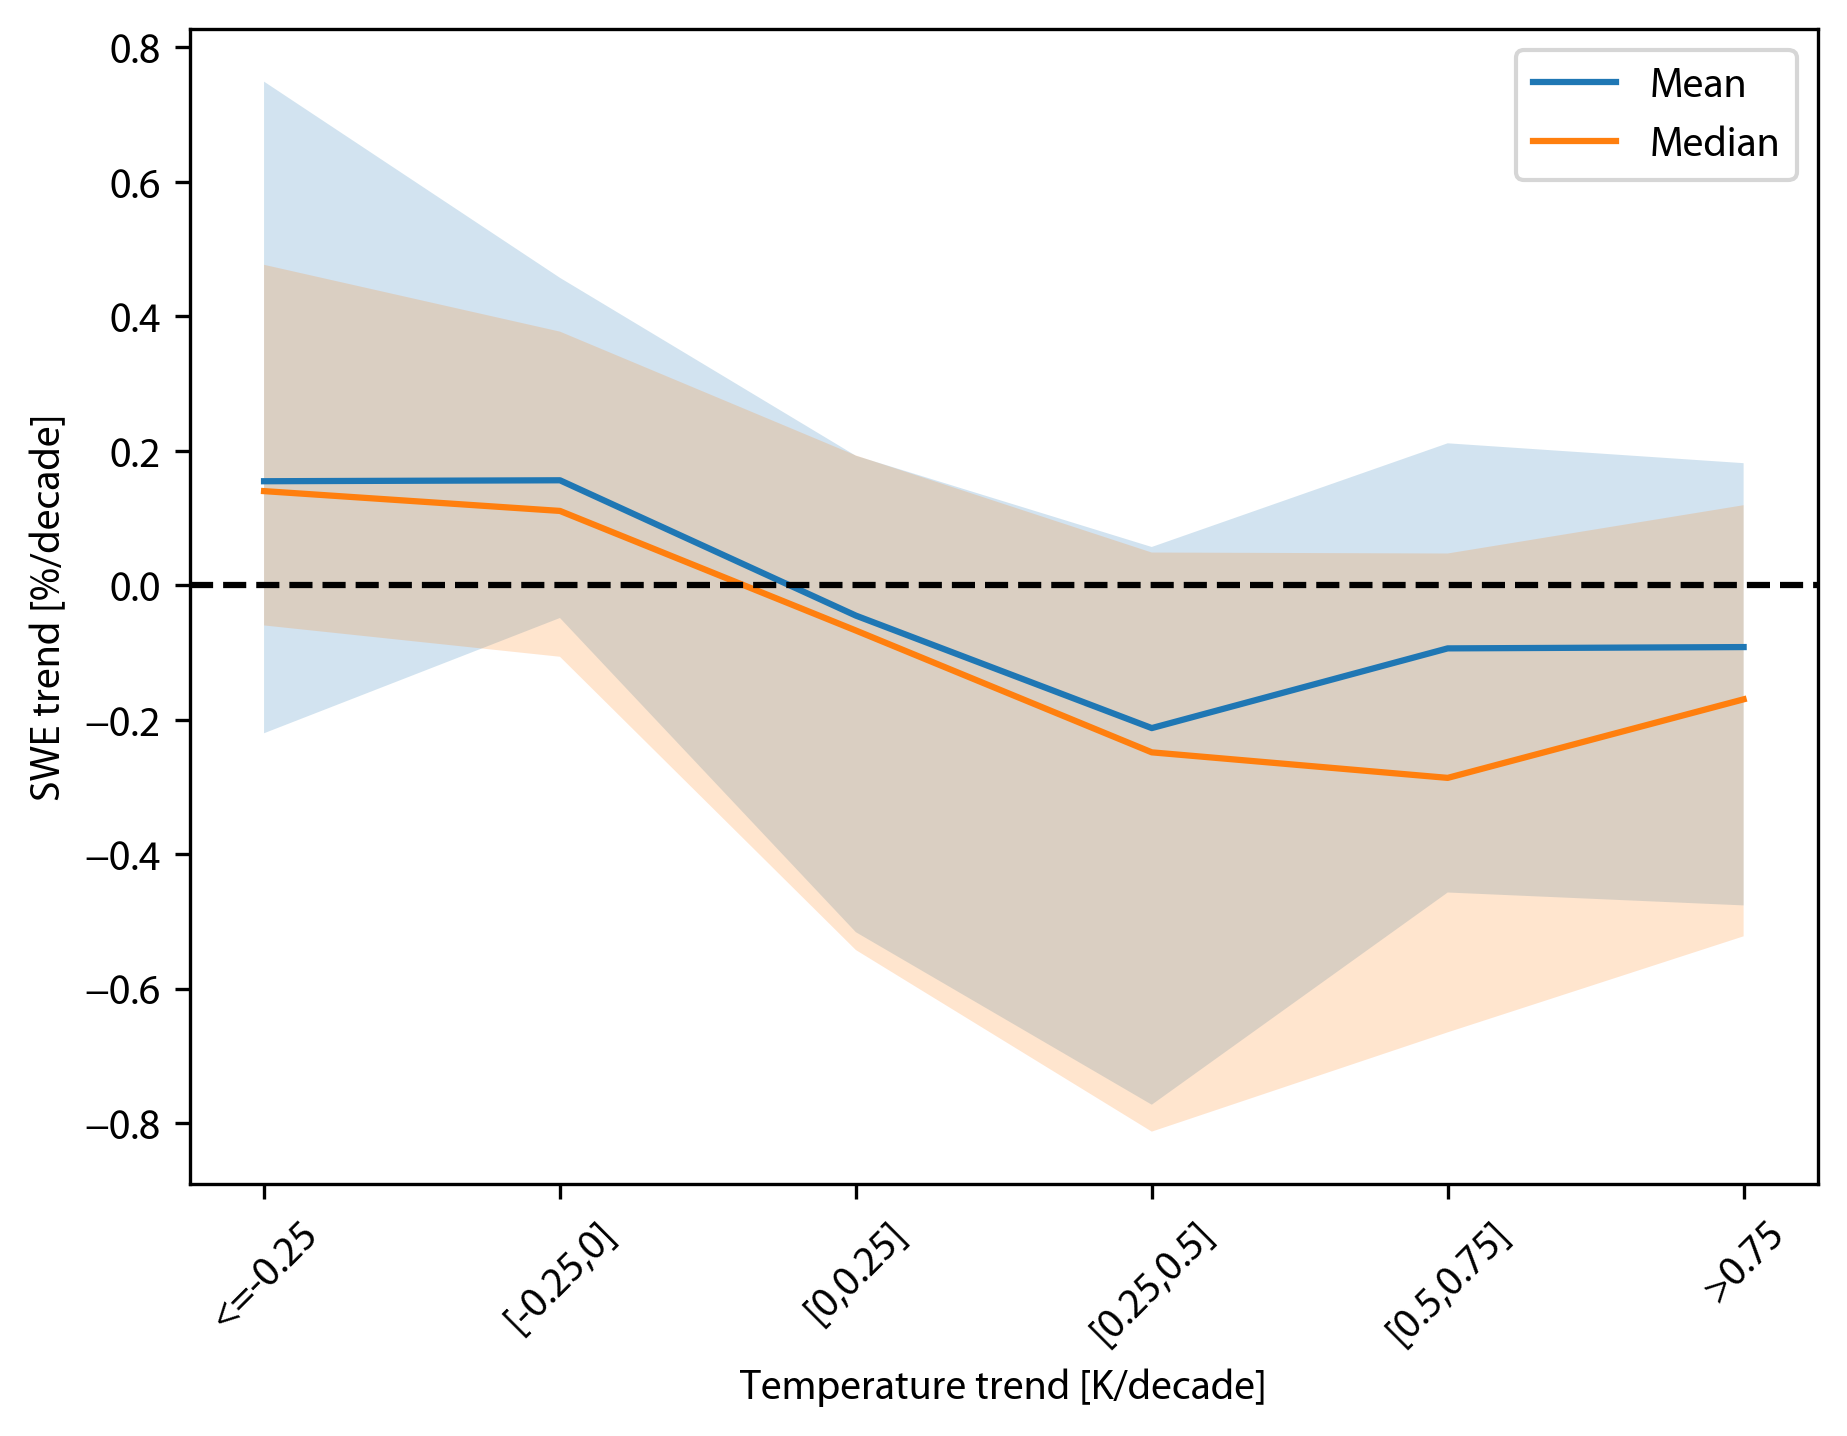

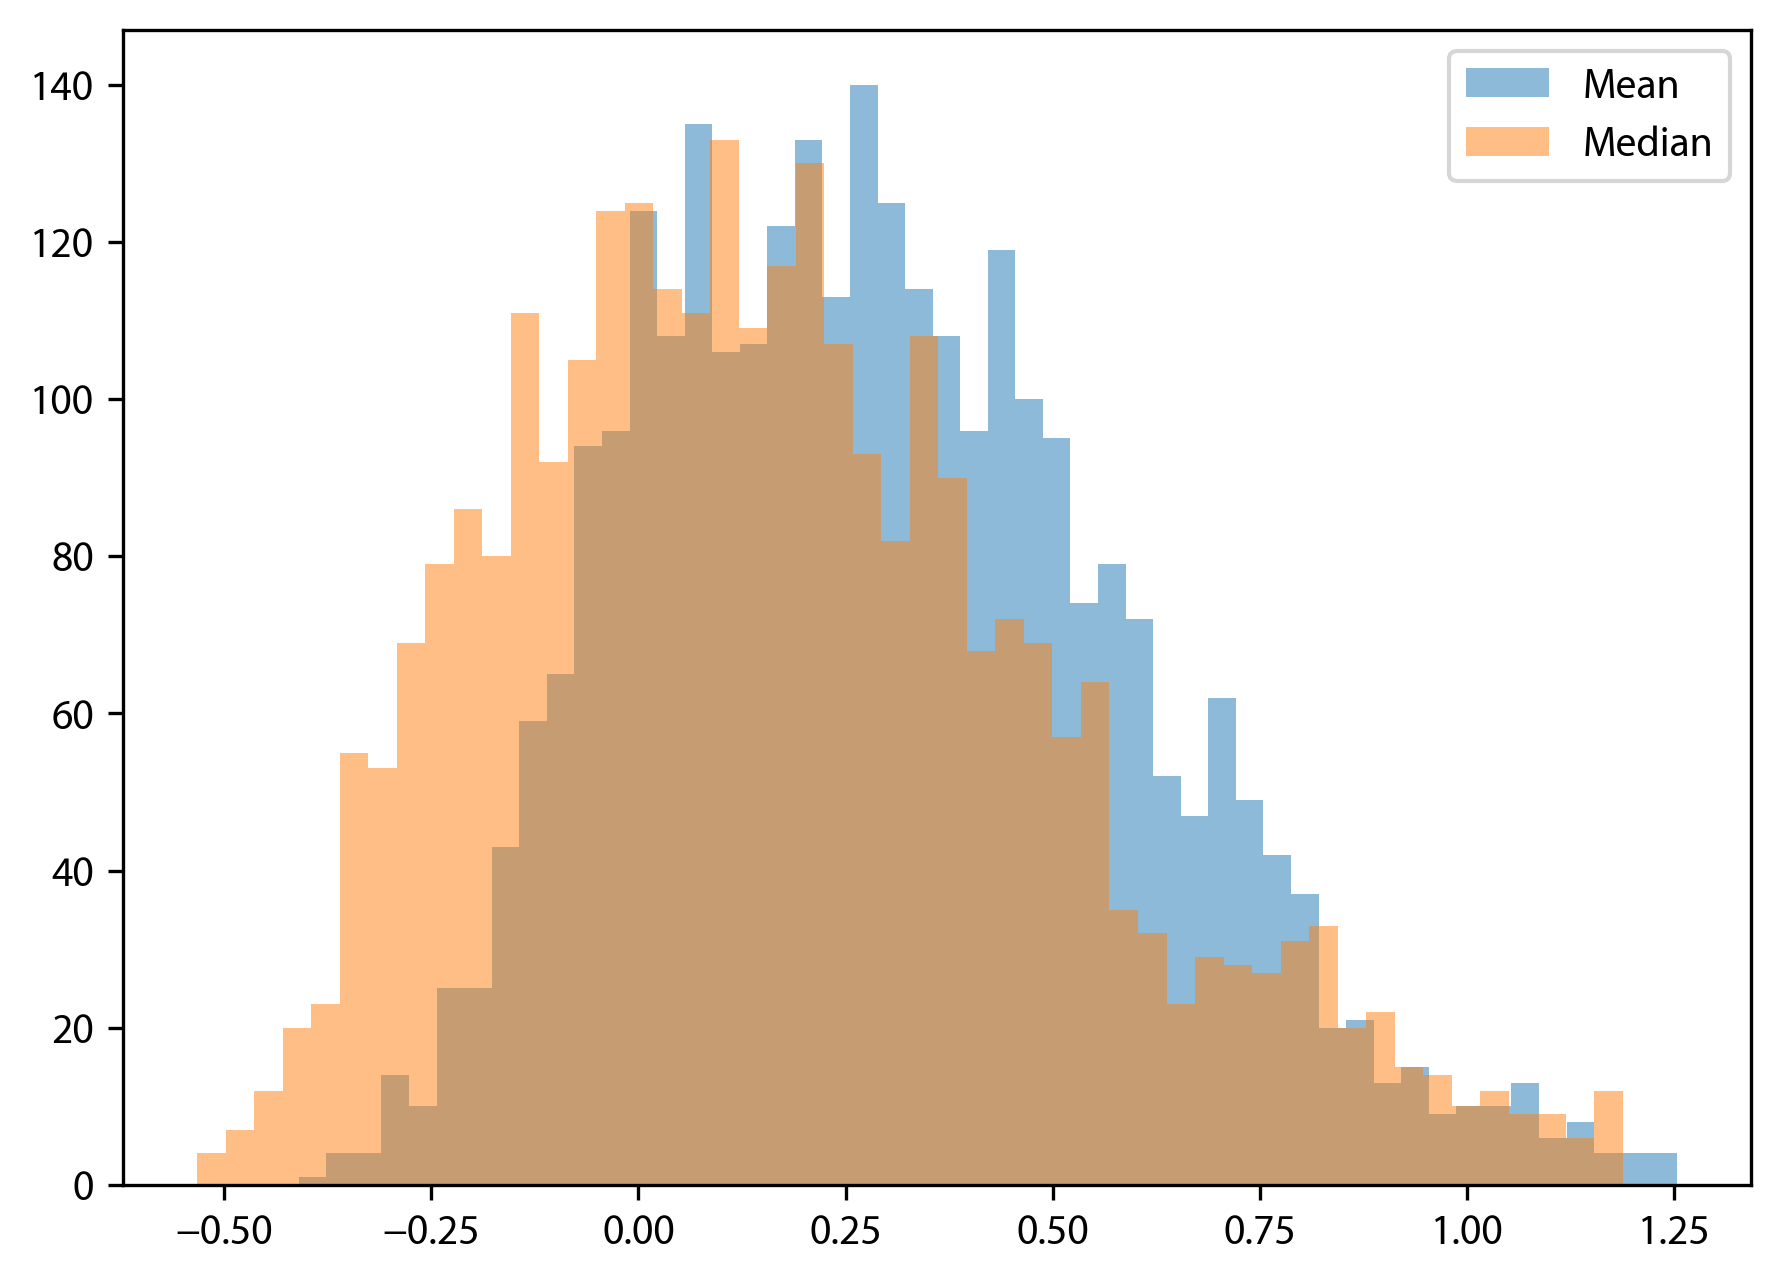

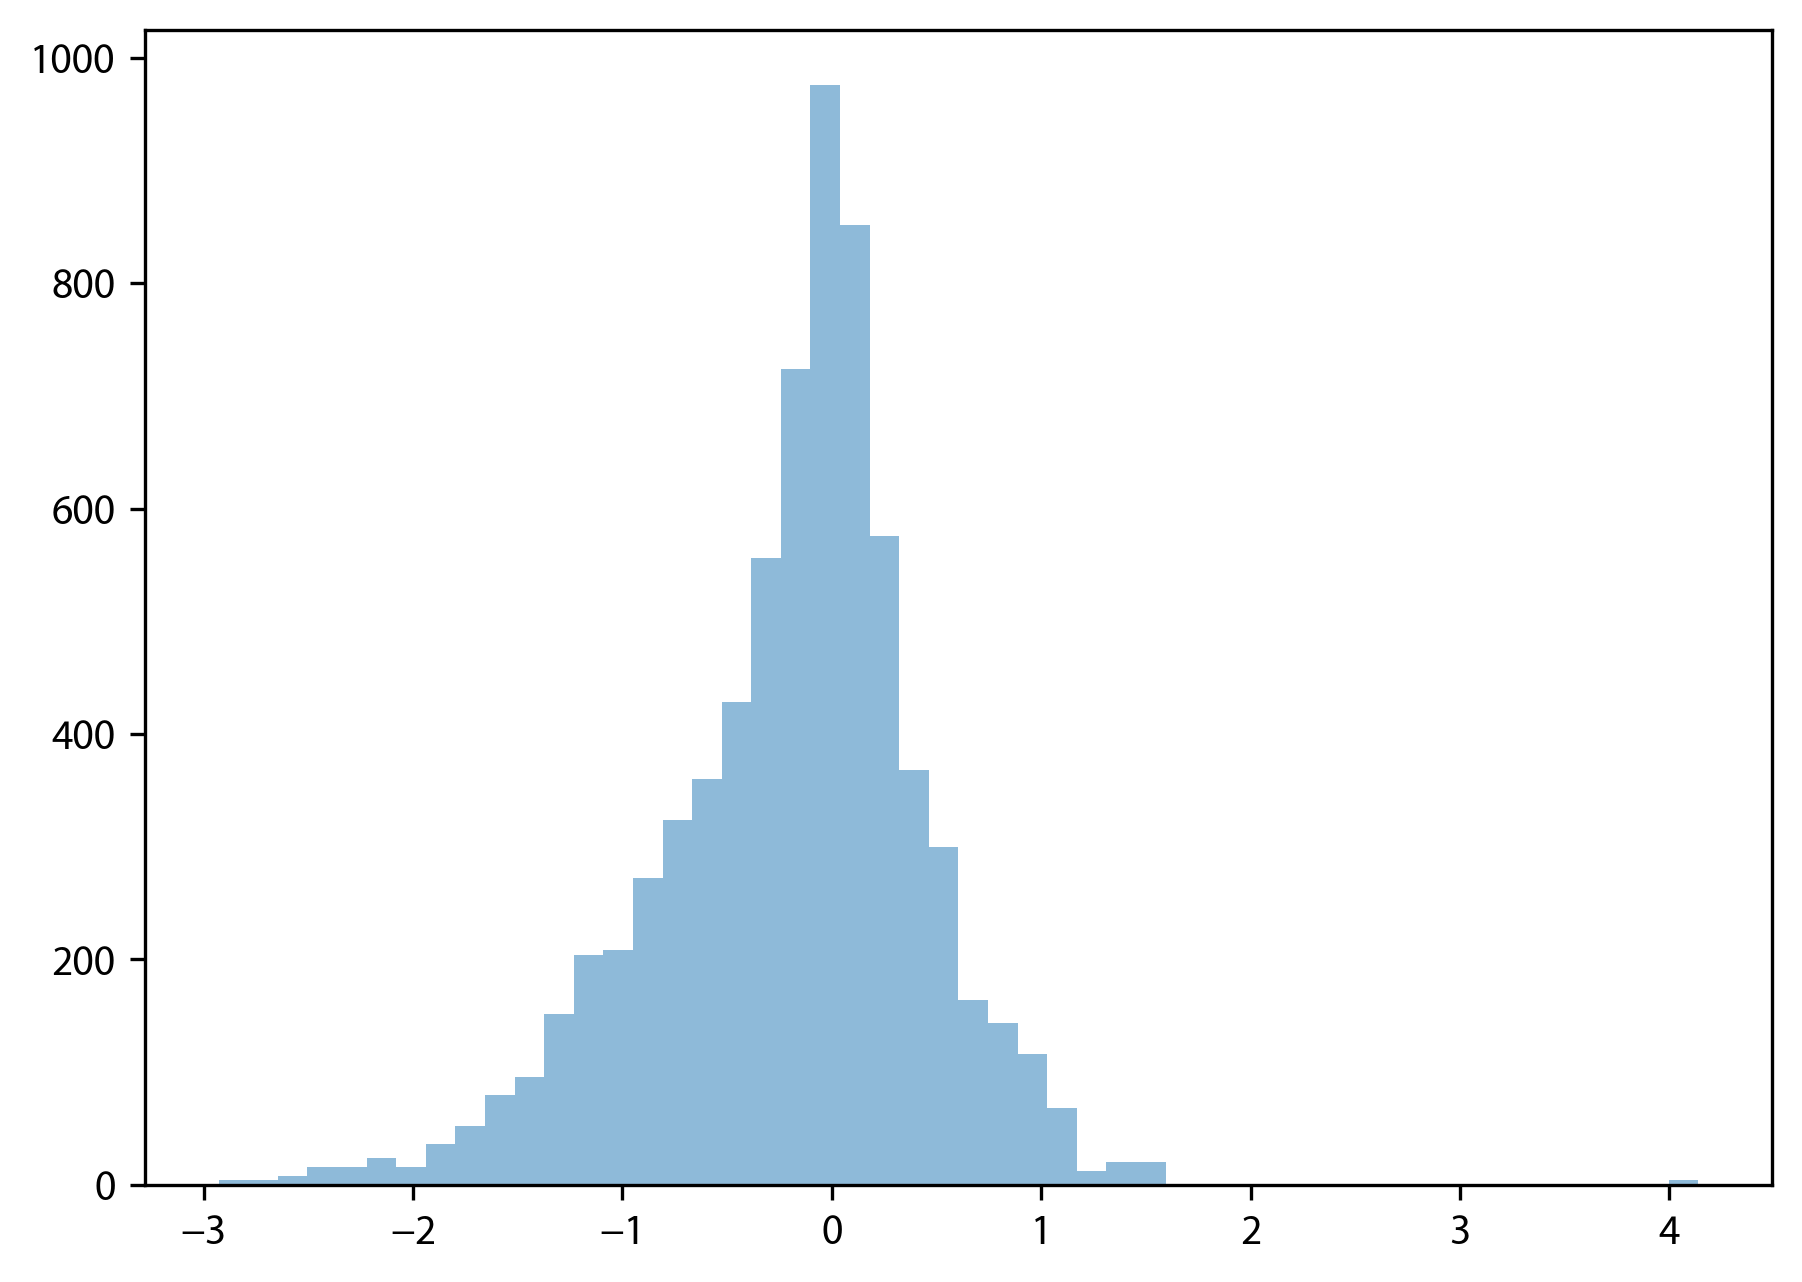

In [80]:
bins = [-0.25, 0, 0.25, 0.5, 0.75]

label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

grouped_indices = np.digitize(comp_gridded[:,0], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_gridded[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(np.arange(len(bins)+1), swe_mid, label='Mean')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)


grouped_indices = np.digitize(comp_gridded[:,1], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_gridded[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

ax.plot(np.arange(len(bins)+1), swe_mid, label='Median')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)

ax.set_xticks(np.arange(len(bins)+1))
ax.set_xticklabels(label_str)
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_ylabel('SWE trend [%/decade]')
ax.set_xlabel('Temperature trend [K/decade]')

ax.axline((0, 0), slope=0, color='black', linestyle='--')

sel_idx = np.where(comp_gridded[:,2] > 0)[0]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(comp_gridded[sel_idx,0], bins=50, alpha=0.5, label='Mean')
ax.hist(comp_gridded[sel_idx,1], bins=50, alpha=0.5, label='Median')
ax.legend()
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(comp_gridded[:, 2], bins=50, alpha=0.5, label='SWE')

(array([  8.,   0.,   0.,   0.,   4.,   0.,   8.,   4.,   8.,   4.,  12.,
          8.,   8.,  16.,  28.,  12.,  24.,  40.,  24.,  64.,  60.,  92.,
        156., 204., 244., 300., 224., 152., 104.,  72.,  56.,  36.,  44.,
         20.,  24.,  24.,  24.,   4.,  24.,   4.,   8.,   0.,   0.,   0.,
          0.,   0.,   4.,   0.,   0.,   4.]),
 array([-5.80484984, -5.56741429, -5.32997875, -5.0925432 , -4.85510766,
        -4.61767211, -4.38023656, -4.14280102, -3.90536547, -3.66792993,
        -3.43049438, -3.19305884, -2.95562329, -2.71818775, -2.4807522 ,
        -2.24331666, -2.00588111, -1.76844557, -1.53101002, -1.29357448,
        -1.05613893, -0.81870339, -0.58126784, -0.3438323 , -0.10639675,
         0.13103879,  0.36847434,  0.60590988,  0.84334543,  1.08078097,
         1.31821652,  1.55565206,  1.79308761,  2.03052315,  2.2679587 ,
         2.50539425,  2.74282979,  2.98026534,  3.21770088,  3.45513643,
         3.69257197,  3.93000752,  4.16744306,  4.40487861,  4.64231415,
 

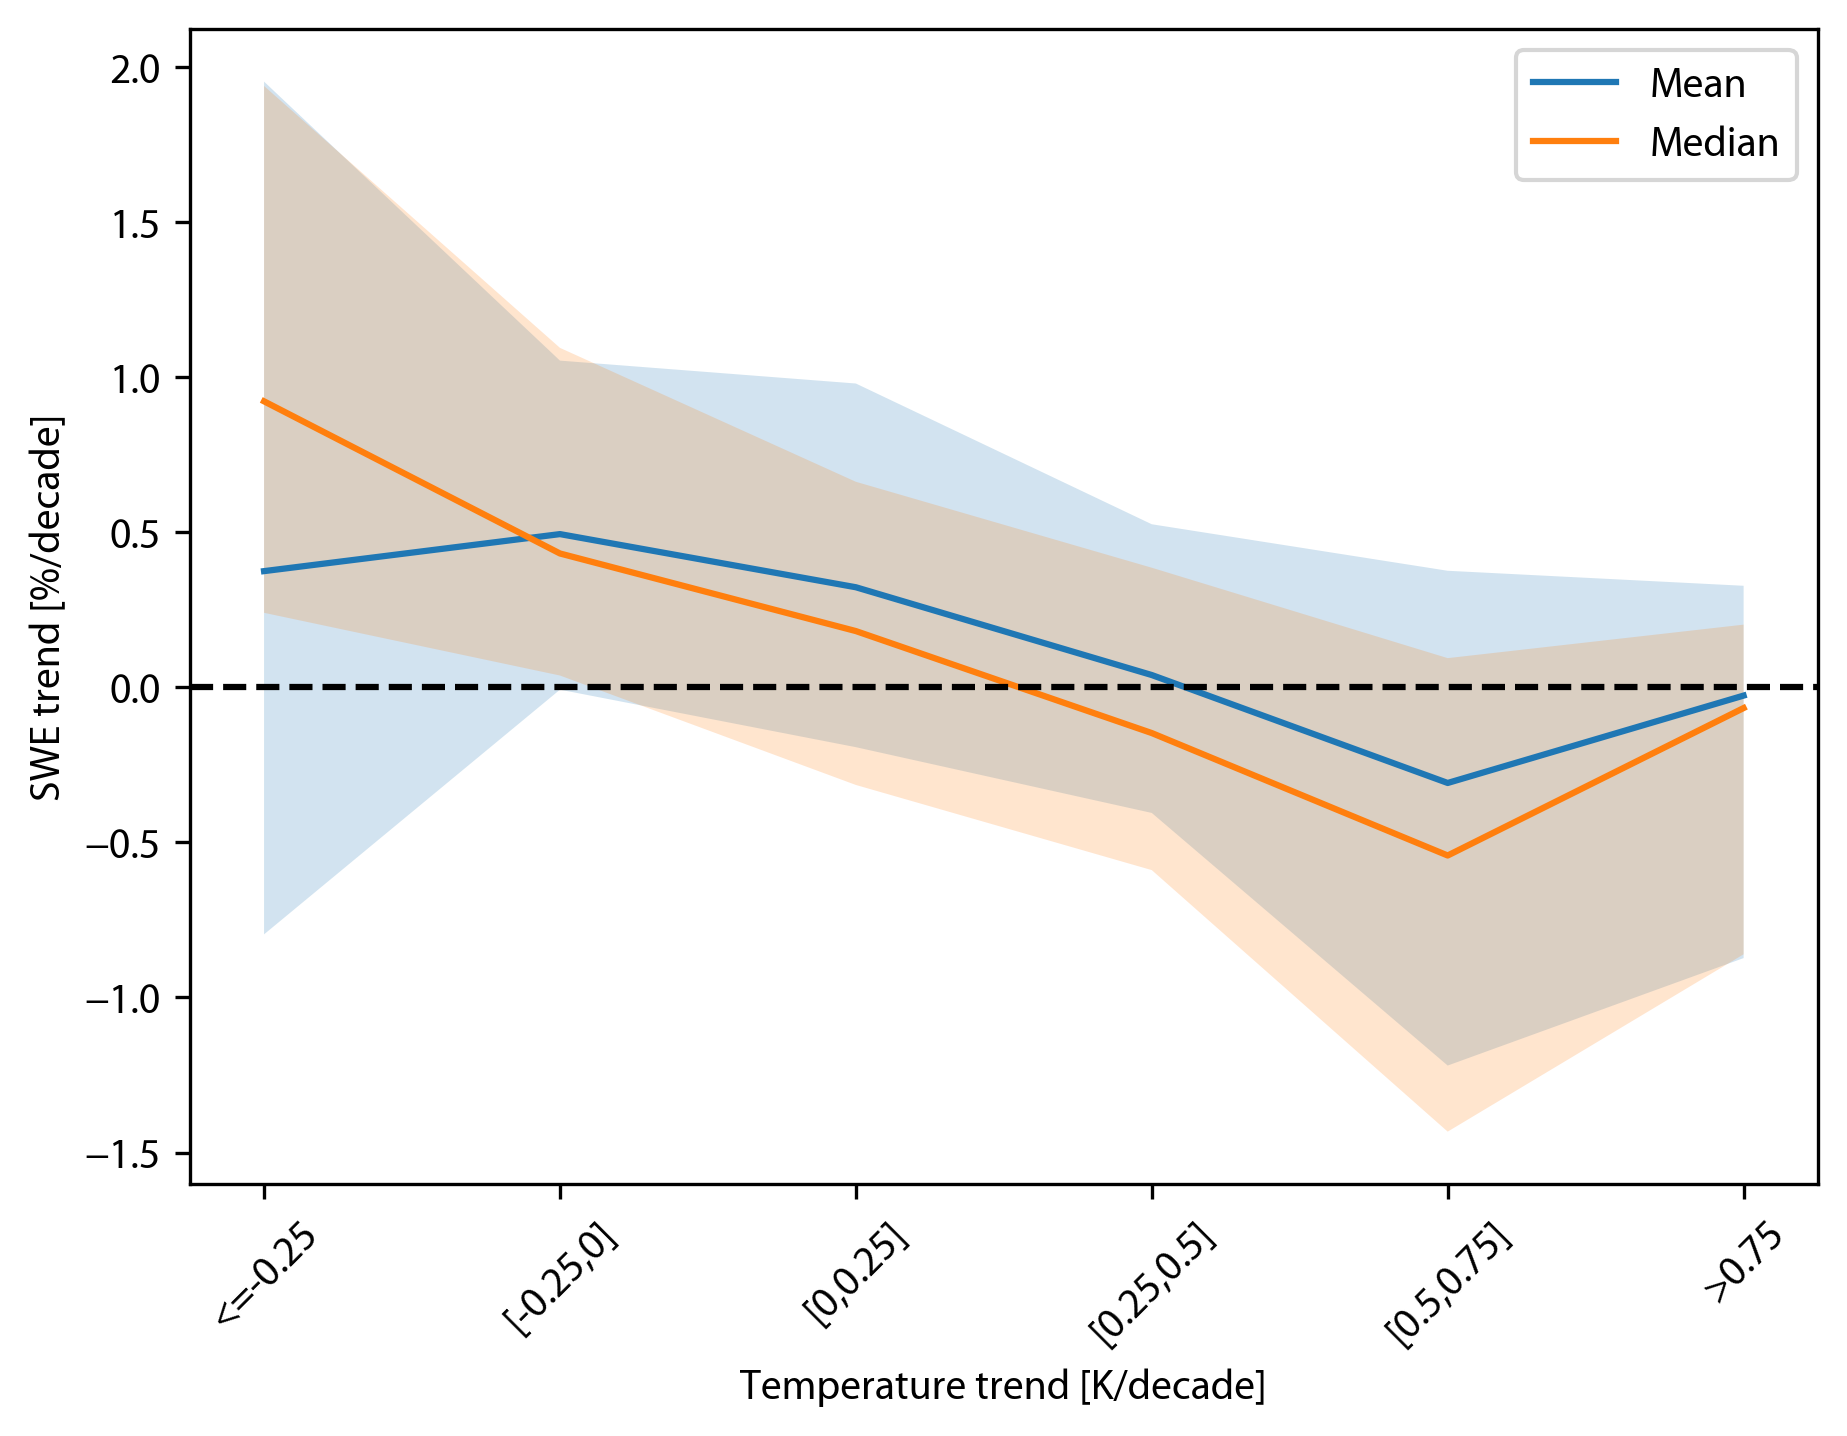

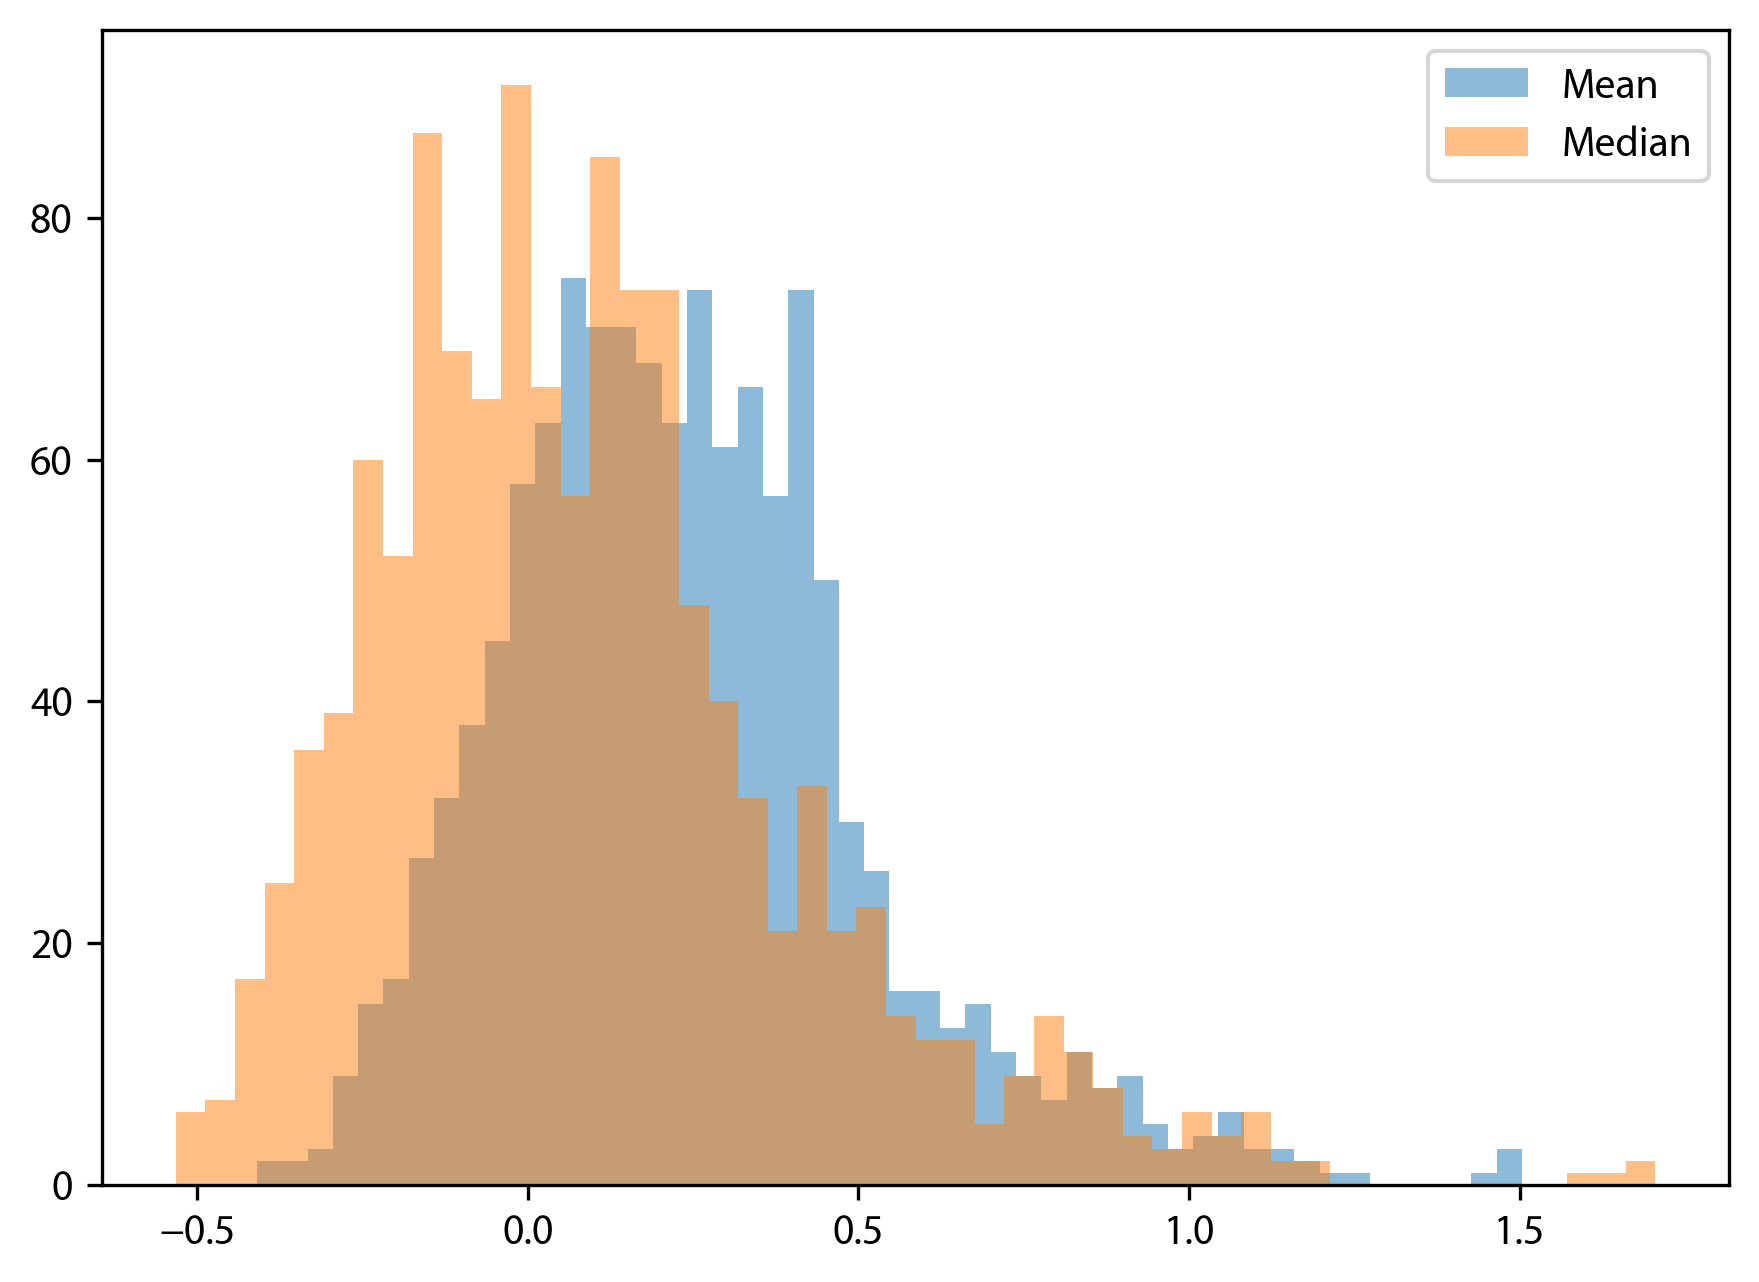

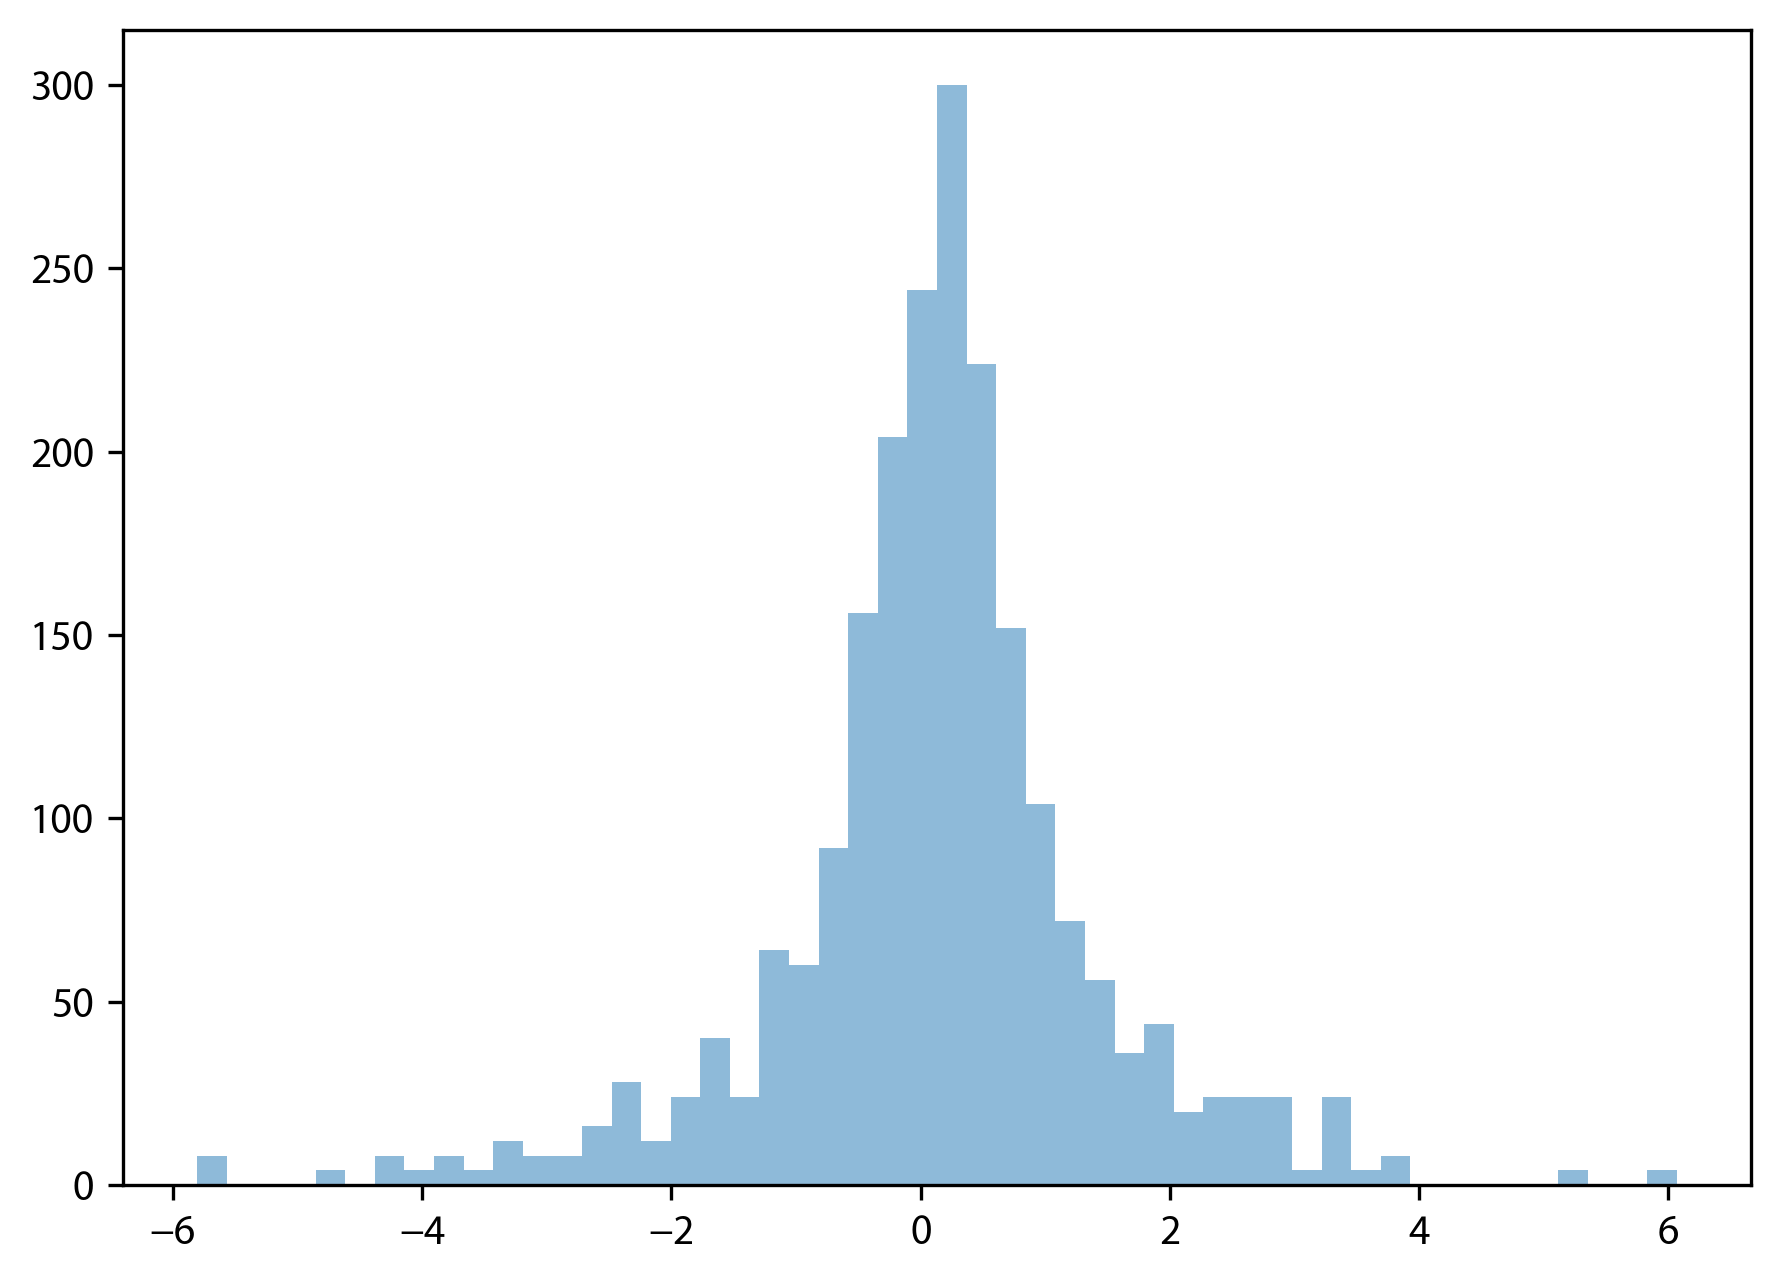

In [81]:
bins = [-0.25, 0, 0.25, 0.5, 0.75]

label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

grouped_indices = np.digitize(comp_insitu[:,0], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_insitu[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(np.arange(len(bins)+1), swe_mid, label='Mean')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)


grouped_indices = np.digitize(comp_insitu[:,1], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_insitu[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

ax.plot(np.arange(len(bins)+1), swe_mid, label='Median')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)

ax.set_xticks(np.arange(len(bins)+1))
ax.set_xticklabels(label_str)
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_ylabel('SWE trend [%/decade]')
ax.set_xlabel('Temperature trend [K/decade]')

ax.axline((0, 0), slope=0, color='black', linestyle='--')

sel_idx = np.where(comp_insitu[:,2] > 0)[0]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(comp_insitu[sel_idx,0], bins=50, alpha=0.5, label='Mean')
ax.hist(comp_insitu[sel_idx,1], bins=50, alpha=0.5, label='Median')
ax.legend()
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(comp_insitu[:, 2], bins=50, alpha=0.5, label='SWE')


1990
-0.30028512335614266
1974
-0.16296251648695342
1791
-0.34920136851416583
1445
-0.1419866073464781


/tmp/ipykernel_91560/3028115154.py:37: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(k_temp_group[i], k_swe_group[i], s=5, edgecolors='none', marker=marker_type[i], color=color_type[i], label=label_str[i])
/tmp/ipykernel_91560/3028115154.py:37: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(k_temp_group[i], k_swe_group[i], s=5, edgecolors='none', marker=marker_type[i], color=color_type[i], label=label_str[i])
/tmp/ipykernel_91560/3028115154.py:37: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(k_temp_group[i], k_swe_gro

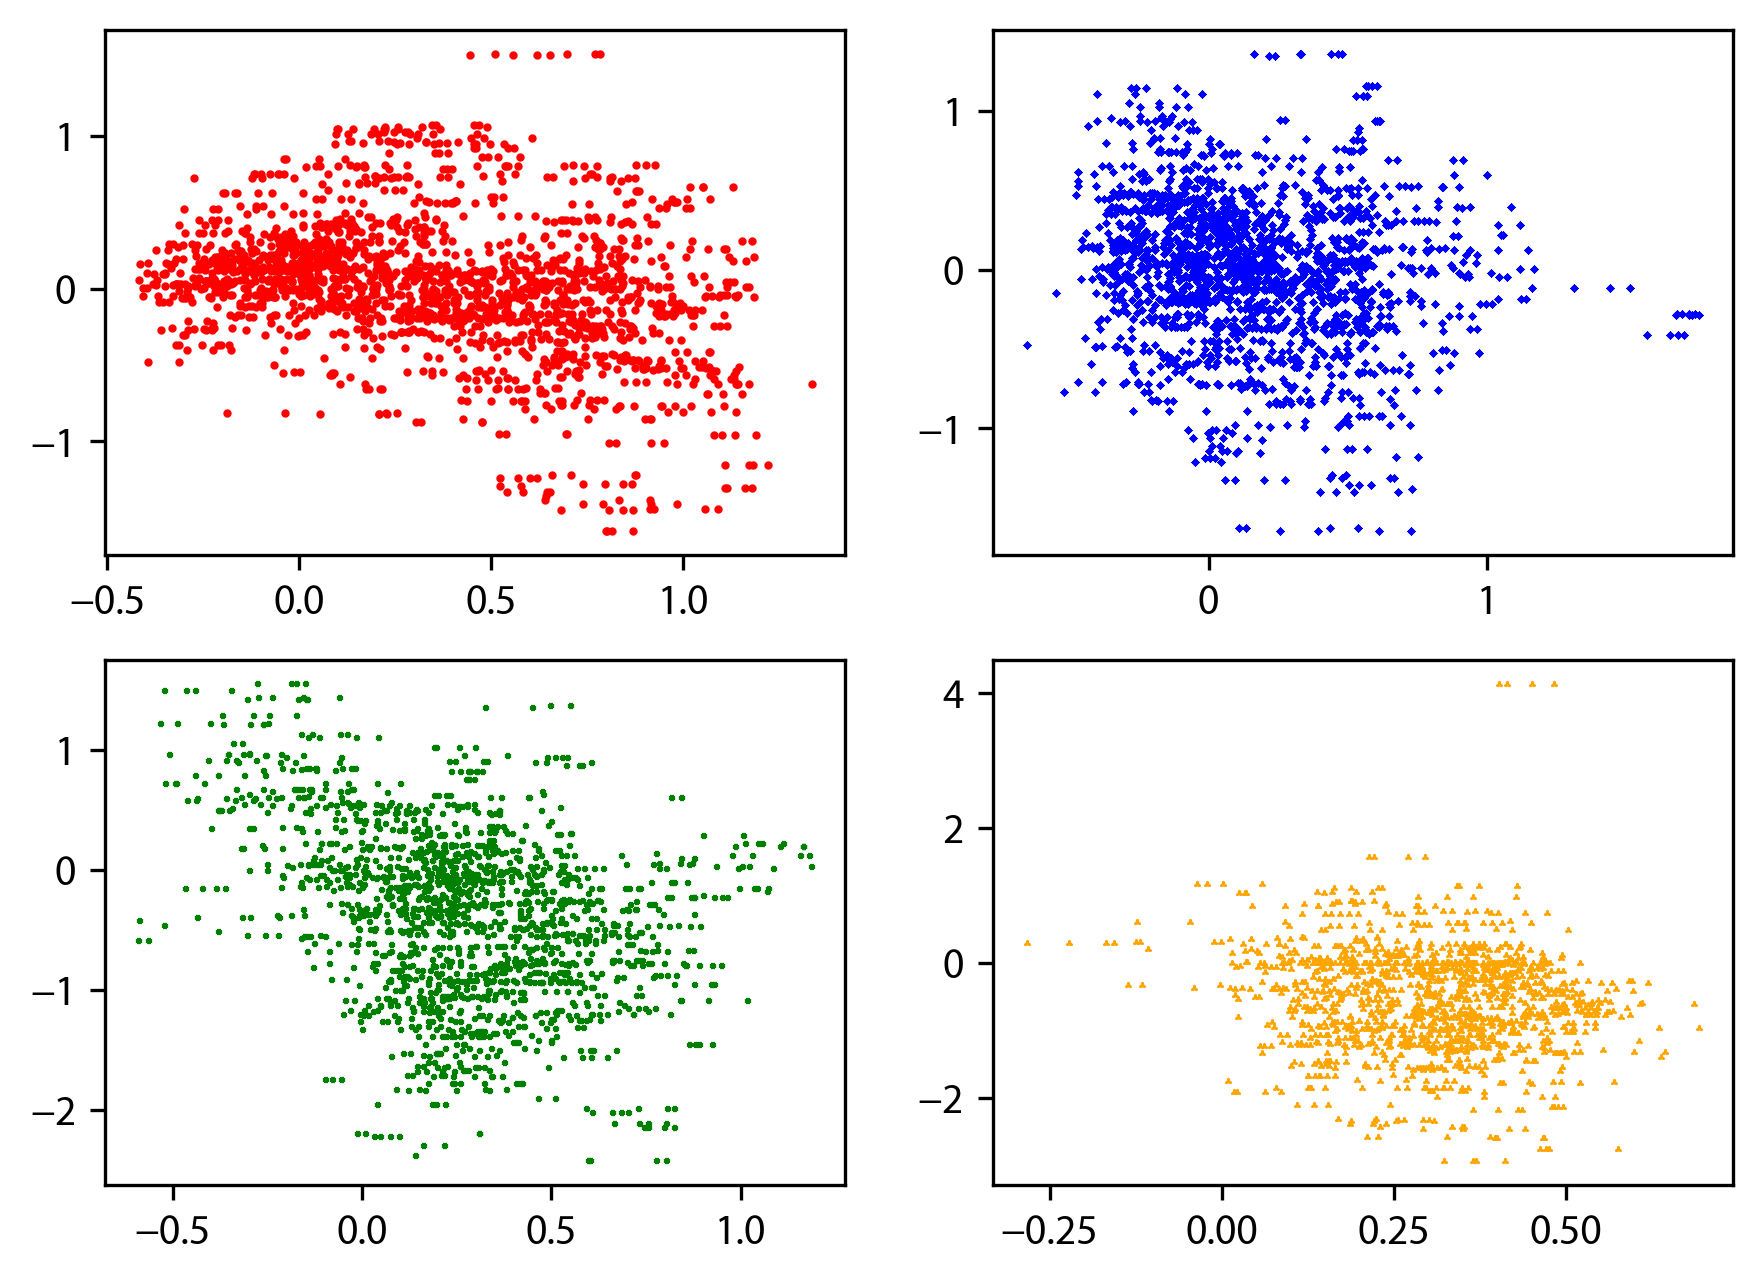

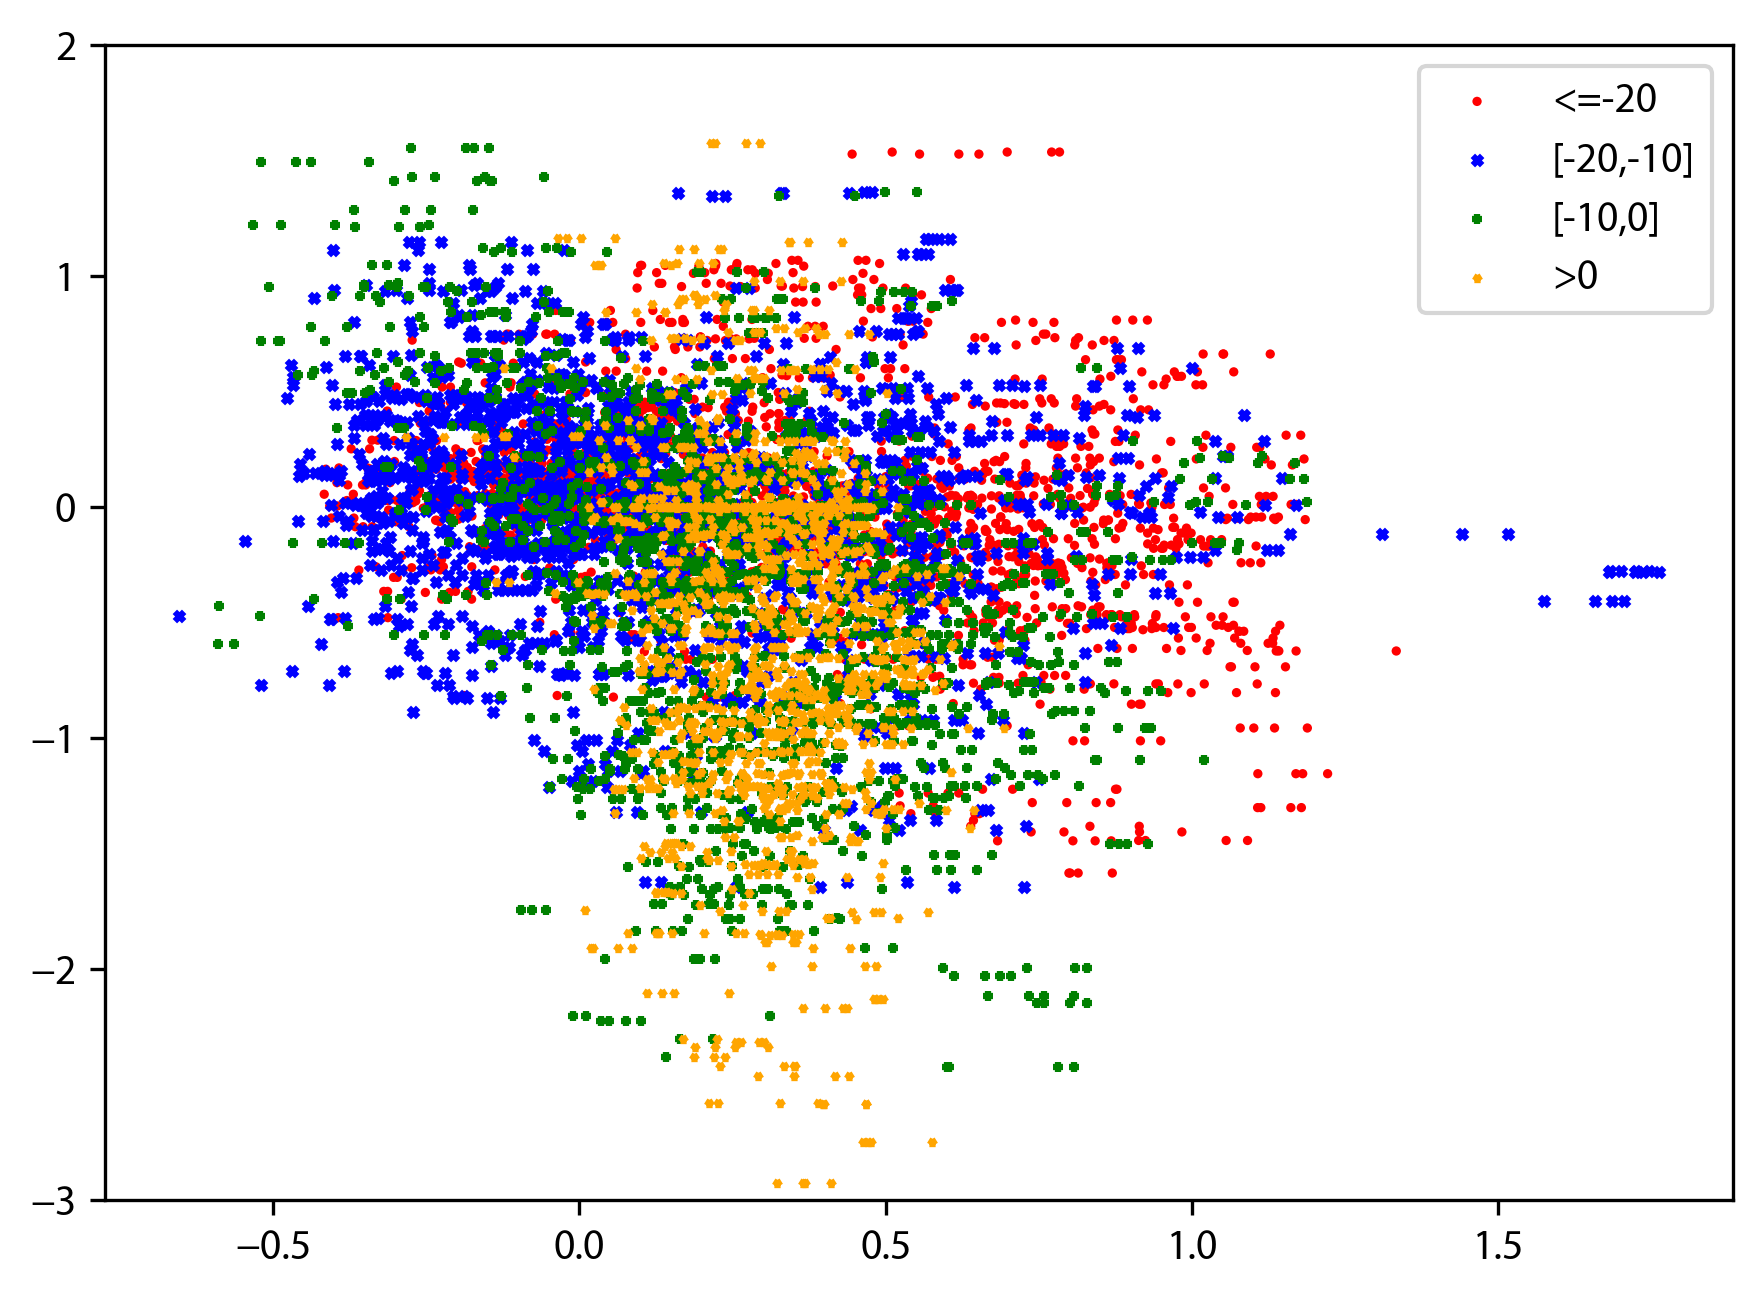

In [82]:
# Define the bins and corresponding labels
bins = [-20, -10, 0]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(climatology_v, bins)

k_temp_group = {}
k_swe_group = {}
climatology_group = {}

for i in range(len(bins)+1):
    k_temp_group[i] = []
    k_swe_group[i] = []
    climatology_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    k_temp_group[group_id].append(comp_gridded[idx,0])
    k_swe_group[group_id].append(comp_gridded[idx,2])
    climatology_group[group_id].append(climatology_v[idx])

marker_type = ['o', 'x', '+', '1', '2', '3']
color_type = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
for i in range(len(bins)+1):
    row_idx, col_idx = i // 2, i % 2
    ax[row_idx, col_idx].scatter(k_temp_group[i], k_swe_group[i], s=1, marker=marker_type[i], color=color_type[i])
    print(len(k_temp_group[i]))
    print(np.corrcoef(k_temp_group[i], k_swe_group[i])[0,1])
    # ax[row_idx, col_idx].set_xlim(-0.5, 1.5)
    # ax[row_idx, col_idx].set_ylim(-3, 2)  
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in range(len(bins)+1):
    ax.scatter(k_temp_group[i], k_swe_group[i], s=5, edgecolors='none', marker=marker_type[i], color=color_type[i], label=label_str[i])
    # ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-3, 2)
    ax.legend()

In [49]:
5 % 3 

2